In [1]:
import os.path
from os import path
import requests
import shutil
import cv2

from sklearn.cluster import MiniBatchKMeans

PATH_TO_RESOURCES = "../resources"

In [2]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [3]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [4]:
symbols = [load_image(symbol_file) for symbol_file in symbol_files]

In [5]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(symbols, symbols_labels, test_size=0.2, stratify=symbols_labels)

In [8]:
class RGBSymbolExtractor():
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def transform(self, X, copy=None):
        return [symbol[np.sum(symbol, axis=2) < 255 * 3] for symbol in X]

In [9]:
class ColorHistogram():
    def __init__(self):
        self.kmeans = MiniBatchKMeans(8)
        
    def fit(self, X, y=None, sample_weight=None):
        sample_pixels = X[0]
        for i in range(1, len(X)):
            sample_pixels = np.concatenate((sample_pixels, X[i]), axis=0)

        self.kmeans.fit(sample_pixels)
        
        return self
    
    def transform(self, X, copy=None):
        histograms = []
        for i in range(len(X)):
            histo = np.bincount(np.uint8(self.kmeans.predict(X[i])),
                        minlength = self.kmeans.n_clusters) / len(X[i])
            histograms.append(histo)

        return histograms

In [10]:
pipeline_transformers = [("extraction", RGBSymbolExtractor())]

In [11]:
extractor = ("color histogram", ColorHistogram())

## Useful fonctions

In [12]:
from sklearn.pipeline import Pipeline
import time
import matplotlib.pyplot as plt

In [13]:
def test_pipeline(classifier):
    steps = pipeline_transformers + [extractor, classifier]
    pipeline = Pipeline(steps)

    fit_time = 0
    score = 0
    score_time = 0
    NB_STEP = 3
    for _ in range(NB_STEP):
        start = time.process_time()
        pipeline.fit(X_train, y_train)
        fit_time += time.process_time() - start

        start = time.process_time()
        score += pipeline.score(X_test, y_test)
        score_time += time.process_time() - start
    
    return score / NB_STEP * 100, fit_time / NB_STEP, score_time / NB_STEP

In [14]:
def benchmark2str_repr(name, score, fit_time, score_time):
    return name, "{:.3f} %".format(score), "{:.3f} s".format(fit_time), "{:.3f} s".format(score_time)

In [15]:
def print_benchmark(benchmark, arg_name):
    fig, ax =plt.subplots()
    column_labels=[arg_name, "Score", "CPU fit time", "CPU score time"]
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=benchmark,
                     colLabels=column_labels,
                     loc="center",
                     cellLoc="center")

    table.set_fontsize(20)
    table.scale(2, 2)

    plt.show()

## LinearSVC

In [16]:
from sklearn.svm import LinearSVC

On teste l'argument loss, c'est-à-dire la fonction de perte, qui peut être 'hinge', la fonction de perte standard, ou 'squared_hinge', qui est son carré.

/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


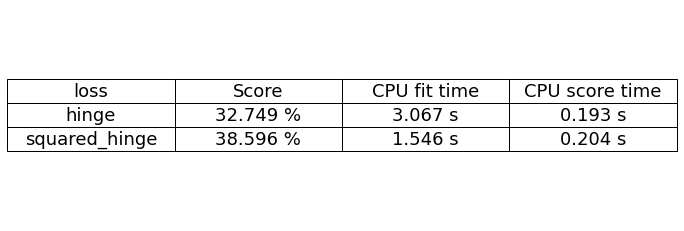

In [17]:
benchmark = []

classifier = ("LinearSVC clf", LinearSVC(loss='hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("hinge", score, fit_time, score_time))

classifier = ("LinearSVC clf", LinearSVC(loss='squared_hinge'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("squared_hinge", score, fit_time, score_time))

print_benchmark(benchmark, "loss")

On teste maintenant la tolérance d'arrêt, tol.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


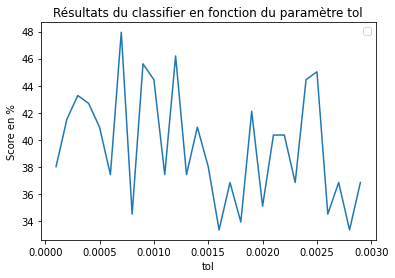

In [29]:
x_axis = []
scores = []

for i in range(1, 30):
    classifier = ("LinearSVC clf", LinearSVC(tol=i/10000))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10000)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre tol")
plt.xlabel("tol")
plt.ylabel("Score en %")
plt.legend()

plt.show()

Enfin, on teste le paramètre de régularisation, C.

/home/nicolas/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


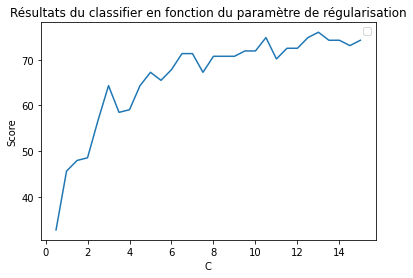

In [30]:
x_axis = []
scores = []

for i in range(5, 155, 5):
    classifier = ("LinearSVC clf", LinearSVC(C=i/10))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

plt.show()

# TODO blabla sur ce qu'on peut ressortir

## KNeighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

On teste d'abord le paramètre déterminant le nombre de voisins.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


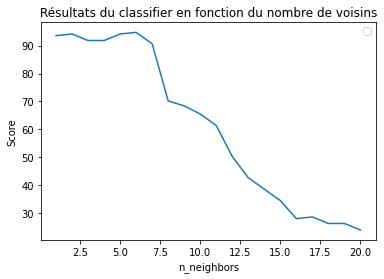

In [31]:
x_axis = []
scores = []

for i in range(1, 21):
    classifier = ("KNeighbours clf", KNeighborsClassifier(n_neighbors = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(int(i))
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du nombre de voisins")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.legend()

plt.show()

Ensuite, teste en fonction des poids : soit "uniform", où tous les points ont le même poids, soit "distance", où leur poids est l'inverse de leur distance, donc les voisins proches ont plus d'influence.

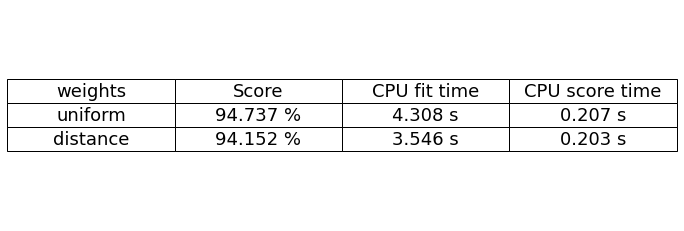

In [22]:
benchmark = []

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'uniform'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("uniform", score, fit_time, score_time))

classifier = ("KNeighbours clf", KNeighborsClassifier(weights = 'distance'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("distance", score, fit_time, score_time))

print_benchmark(benchmark, "weights")

Enfin, testons en fonction de la taille des feuilles, leaf_size.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


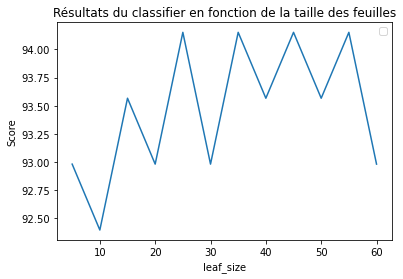

In [32]:
x_axis = []
scores = []

for i in range(5, 65, 5):
    classifier = ("KNeighbours clf", KNeighborsClassifier(leaf_size = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction de la taille des feuilles")
plt.xlabel("leaf_size")
plt.ylabel("Score")
plt.legend()

plt.show()

## KNeighbors

In [24]:
from sklearn.svm import SVC

On teste tout d'abord le paramètre de régularisation, C.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


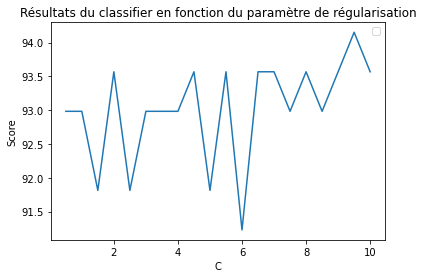

In [33]:
x_axis = []
scores = []

for i in range(5, 105, 5):
    classifier = ("SVC clf", SVC(C=i/10))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i/10)
    scores.append(score)
    
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du paramètre de régularisation")
plt.xlabel("C")
plt.ylabel("Score")
plt.legend()

plt.show()

On teste maintenant le paramètre kernel.

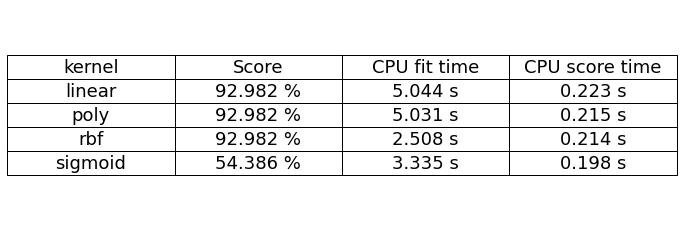

In [26]:
benchmark = []

classifier = ("SVC clf", SVC(kernel = 'linear'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("linear", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'poly'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("poly", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'rbf'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("rbf", score, fit_time, score_time))

classifier = ("SVC clf", SVC(kernel = 'sigmoid'))
score, fit_time, score_time = test_pipeline(classifier)
benchmark.append(benchmark2str_repr("sigmoid", score, fit_time, score_time))

print_benchmark(benchmark, "kernel")

Enfin, testons le paramètre degree (correspondant au degré de la fonction polynomiale du kernel (si on met 'poly' en paramètre kernel).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


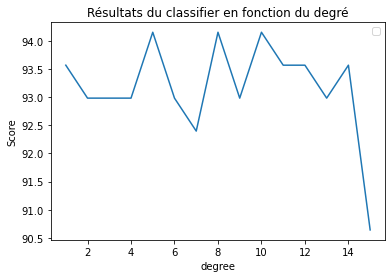

In [34]:
x_axis = []
scores = []

for i in range(1, 16):
    classifier = ("SVC clf", SVC(kernel = 'poly', degree = i))
    score, fit_time, score_time = test_pipeline(classifier)
    x_axis.append(i)
    scores.append(score)
                  
plt.plot(x_axis, scores)
plt.title("Résultats du classifier en fonction du degré")
plt.xlabel("degree")
plt.ylabel("Score")
plt.legend()

plt.show()

# TODO BLABLABLA